
Run 1/5
Converged at state 15 with path length 7, cost 6, total reward 1.0

Run 2/5
Converged at state 15 with path length 7, cost 6, total reward 1.0

Run 3/5
Converged at state 15 with path length 7, cost 6, total reward 1.0

Run 4/5
Converged at state 15 with path length 7, cost 6, total reward 1.0

Run 5/5
Converged at state 15 with path length 7, cost 6, total reward 1.0

BranchAndBound | Success: 5/5 | Avg Time: 0.0019s | Avg Reward: 1.00


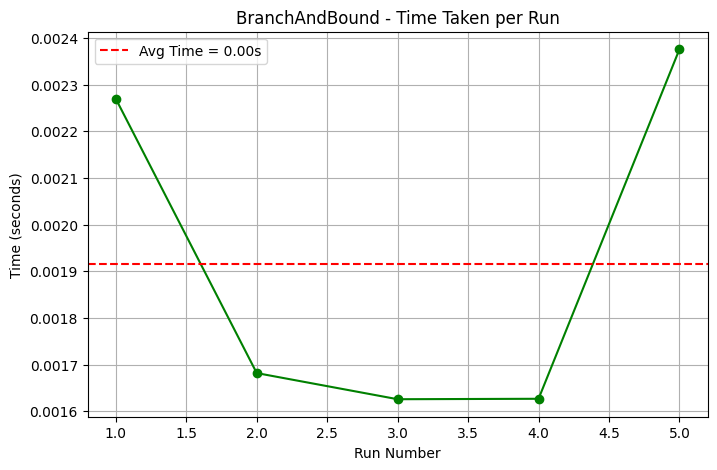

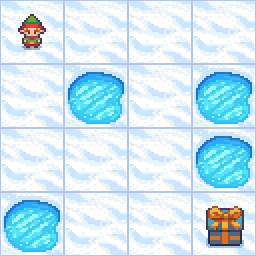

In [195]:
!pip install gymnasium[other] imageio matplotlib -q

import gymnasium as gym
import numpy as np
import time
import random
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
import heapq
import os

env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
goal_state = 15

def state_to_pos(state, grid_size=4):
    return (state // grid_size, state % grid_size)

def branch_and_bound(env):
    obs, info = env.reset()
    start_state = env.unwrapped.s
    visited = set()
    pq = [(0, start_state, [], 0)]

    while pq:
        cost, state, path, total_reward = heapq.heappop(pq)
        if state in visited:
            continue
        visited.add(state)
        path = path + [state]

        if state == goal_state:
            print(f"Converged at state {state} with path length {len(path)}, cost {cost}, total reward {total_reward}")
            return path, total_reward

        for action in range(env.action_space.n):
            env.unwrapped.s = state
            next_state, reward, _, _, _ = env.step(action)
            if next_state not in visited:
                heapq.heappush(pq, (cost + 1, next_state, path, total_reward + reward))

    print("Did not converge within limit.")
    return None, 0

def create_gif(path, filename="demo.gif"):
    frames = []
    for state in path:
        obs, info = env.reset()
        env.unwrapped.s = state
        frame = env.render()
        frames.append(frame)
    imageio.mimsave(filename, frames, duration=0.4)
    display(Image(filename=filename))

def run_and_evaluate(algo_fn, name):
    times = []
    success = 0
    all_paths = []
    rewards = []
    τ = 600

    for i in range(5):
        print(f"\nRun {i+1}/5")
        start = time.time()
        path = None
        reward = 0

        while time.time() - start < τ:
            path, reward = algo_fn(env)
            if path and path[-1] == goal_state:
                break
            else:
                path = None
                reward = 0

        elapsed = time.time() - start
        times.append(elapsed)

        if path and path[-1] == goal_state:
            success += 1
            all_paths.append(path)
            rewards.append(reward)
        else:
            print(f"Timeout or goal not reached in {τ} seconds.")

    avg_time = sum(times) / len(times)
    avg_reward = sum(rewards) / len(rewards) if rewards else 0

    print(f"\n{name} | Success: {success}/5 | Avg Time: {avg_time:.4f}s | Avg Reward: {avg_reward:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 6), times, marker='o', color='green')
    plt.axhline(avg_time, color='red', linestyle='--', label=f'Avg Time = {avg_time:.2f}s')
    plt.title(f"{name} - Time Taken per Run")
    plt.xlabel("Run Number")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

    if all_paths:
        gif_name = f"{name}_demo.gif"
        create_gif(all_paths[0], gif_name)

run_and_evaluate(branch_and_bound, "BranchAndBound")



Run 1/5
Converged at state 15 with path length 7 and reward 1.0

Run 2/5
Converged at state 15 with path length 7 and reward 1.0

Run 3/5
Converged at state 15 with path length 7 and reward 1.0

Run 4/5
Converged at state 15 with path length 7 and reward 1.0

Run 5/5
Converged at state 15 with path length 7 and reward 1.0

IDAStar | Success: 5/5 | Avg Time: 0.0020s | Avg Reward: 1.00


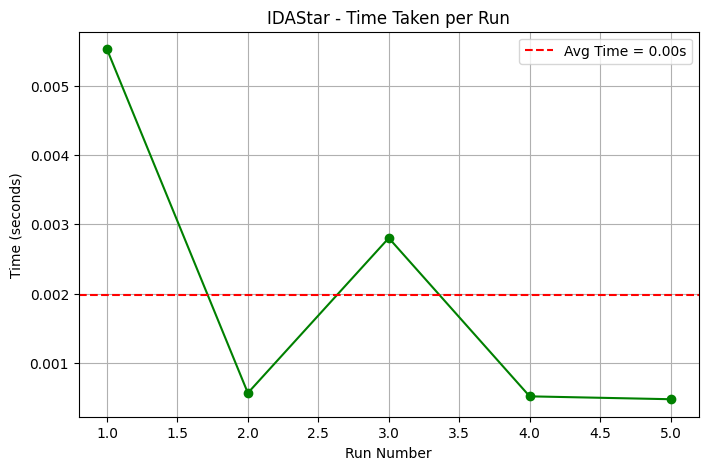

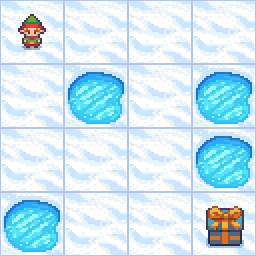

In [198]:
!pip install gymnasium[other] imageio matplotlib -q

import gymnasium as gym
import numpy as np
import time
import random
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display

env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
goal_state = 15

def state_to_pos(state, grid_size=4):
    return (state // grid_size, state % grid_size)

def ida_star(env):
    obs, info = env.reset()
    start_state = env.unwrapped.s
    goal = goal_state

    def heuristic(state):
        row1, col1 = state_to_pos(state)
        row2, col2 = state_to_pos(goal)
        return abs(row1 - row2) + abs(col1 - col2)

    def dfs(path, g, bound, visited, total_reward):
        current = path[-1]
        f = g + heuristic(current)
        if f > bound:
            return f, 0
        if current == goal:
            return path, total_reward
        min_bound = float("inf")
        for action in range(env.action_space.n):
            env.unwrapped.s = current
            next_state, reward, _, _, _ = env.step(action)
            if next_state in visited:
                continue
            visited.add(next_state)
            result, rew = dfs(path + [next_state], g + 1, bound, visited, total_reward + reward)
            if isinstance(result, list):
                return result, rew
            if result < min_bound:
                min_bound = result
            visited.remove(next_state)
        return min_bound, 0

    bound = heuristic(start_state)
    path = [start_state]
    visited = set(path)

    while True:
        result, total_reward = dfs(path, 0, bound, visited, 0)
        if isinstance(result, list):
            print(f"Converged at state {result[-1]} with path length {len(result)} and reward {total_reward}")
            return result, total_reward
        if result == float("inf"):
            print("Did not converge within limit.")
            return None, 0
        bound = result


def create_gif(path, filename="demo.gif"):
    frames = []
    for state in path:
        obs, info = env.reset()
        env.unwrapped.s = state
        frame = env.render()
        frames.append(frame)
    imageio.mimsave(filename, frames, duration=0.4)
    display(Image(filename=filename))

def run_and_evaluate(algo_fn, name):
    times = []
    success = 0
    all_paths = []
    rewards = []
    τ = 600

    for i in range(5):
        print(f"\nRun {i+1}/5")
        start = time.time()
        path = None
        reward = 0

        while time.time() - start < τ:
            path, reward = algo_fn(env)
            if path and path[-1] == goal_state:
                break
            else:
                path = None
                reward = 0

        elapsed = time.time() - start
        times.append(elapsed)

        if path and path[-1] == goal_state:
            success += 1
            all_paths.append(path)
            rewards.append(reward)
        else:
            print(f"Timeout or goal not reached in {τ} seconds.")

    avg_time = sum(times) / len(times)
    avg_reward = sum(rewards) / len(rewards) if rewards else 0

    print(f"\n{name} | Success: {success}/5 | Avg Time: {avg_time:.4f}s | Avg Reward: {avg_reward:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 6), times, marker='o', color='green')
    plt.axhline(avg_time, color='red', linestyle='--', label=f'Avg Time = {avg_time:.2f}s')
    plt.title(f"{name} - Time Taken per Run")
    plt.xlabel("Run Number")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

    if all_paths:
        create_gif(all_paths[0], f"{name}_demo.gif")


run_and_evaluate(ida_star, "IDAStar")


In [177]:
!git clone https://github.com/MicheleCattaneo/ant_colony_opt_TSP.git
%cd ant_colony_opt_TSP


Cloning into 'ant_colony_opt_TSP'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 151 (delta 75), reused 107 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 4.41 MiB | 7.11 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/ant_colony_opt_TSP/ant_colony_opt_TSP


In [178]:
!make


c++ -std=c++11 -O3 aco.cpp -o aco


In [199]:
import os

files = os.listdir("problems_cleaned")
for f in files:
    print(f)


eil76.opt.tour
lin318.tsp
fl1577.tsp
rat783.tsp
pcb442.tsp
kroA100.tsp
eil76.tsp
u1060.tsp
d198.tsp
kroA100.opt.tour
pr439.tsp
ch130.tsp


In [206]:
import matplotlib.pyplot as plt
import numpy as np
import random

def parse_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        start = lines.index('NODE_COORD_SECTION\n') + 1
        end = lines.index('EOF\n')
        coords = []
        for line in lines[start:end]:
            parts = line.strip().split()
            if len(parts) == 3:
                coords.append((float(parts[1]), float(parts[2])))
    return np.array(coords)

def total_distance(coords, tour):
    dist = sum(
        np.linalg.norm(
            np.array(coords[tour[i]]) - np.array(coords[tour[(i + 1) % len(tour)]])
        )
        for i in range(len(tour))
    )
    return dist


def reward_function(distance):
    return -distance


import time

def save_frame(coords, tour, folder, step):
    os.makedirs(folder, exist_ok=True)
    plt.figure(figsize=(6, 6))
    x, y = zip(*[coords[i] for i in tour + [tour[0]]])  # close the loop
    plt.plot(x, y, 'o-', color='blue')
    plt.title(f"Hill Climbing Step {step}")
    plt.axis('equal')
    plt.savefig(f"{folder}/frame_{step}.png")
    plt.close()

def hill_climb(coords, max_iter=5000):
    n = len(coords)
    current_tour = list(range(n))
    np.random.shuffle(current_tour)
    current_dist = total_distance(coords, current_tour)
    current_reward = reward_function(current_dist)

    history = [current_tour.copy()]
    start_time = time.time()
    converged_at = max_iter

    save_frame(coords, current_tour, "gifs/hill_climbing", 0)

    for step in range(1, max_iter + 1):
        i, j = np.random.choice(n, 2, replace=False)
        new_tour = current_tour.copy()
        new_tour[i], new_tour[j] = new_tour[j], new_tour[i]

        new_dist = total_distance(coords, new_tour)
        if new_dist < current_dist:
            current_tour = new_tour
            current_dist = new_dist
            current_reward = reward_function(new_dist)
            history.append(current_tour.copy())
            save_frame(coords, current_tour, "gifs/hill_climbing", step)
            converged_at = step

    end_time = time.time()
    elapsed_time = end_time - start_time

    return current_tour, current_dist, current_reward, elapsed_time, converged_at, history




In [207]:
import matplotlib.pyplot as plt

def plot_tour(coords, tour, filename=None, title="Tour"):
    plt.figure(figsize=(8, 6))
    x = [coords[i][0] for i in tour] + [coords[tour[0]][0]]
    y = [coords[i][1] for i in tour] + [coords[tour[0]][1]]
    plt.plot(x, y, 'o-', markersize=5, linewidth=1.5)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")

    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()


In [208]:
import os
import imageio

def create_gif(coords, history, output_folder="gifs/hill_climbing", gif_name="hill_climb.gif"):
    os.makedirs(output_folder, exist_ok=True)
    images = []
    for step, tour in enumerate(history):
        if step % 10 == 0:
            frame_path = os.path.join(output_folder, f"frame_{step}.png")
            plot_tour(coords, tour, filename=frame_path, title=f"Step {step}")
            images.append(imageio.imread(frame_path))

    gif_path = os.path.join(output_folder, gif_name)
    imageio.mimsave(gif_path, images, duration=0.3)
    print(f"GIF saved to {gif_path}")


In [209]:
def simulated_annealing(coords, initial_temp=1000, cooling_rate=0.995, max_iters=500):
    start_time = time.time()
    tour = list(range(len(coords)))
    random.shuffle(tour)
    current_distance = total_distance(coords, tour)
    best_tour = list(tour)
    best_distance = current_distance
    best_reward = reward_function(current_distance)
    converge_iter = 0
    temp = initial_temp
    reward_history = [best_reward]
    history_tours = []

    for step in range(max_iters):
        a, b = sorted(random.sample(range(len(coords)), 2))
        new_tour = tour[:a] + tour[a:b + 1][::-1] + tour[b + 1:]
        new_distance = total_distance(coords, new_tour)
        delta = new_distance - current_distance

        if delta < 0 or np.exp(-delta / temp) > random.random():
            tour = new_tour
            current_distance = new_distance
            if new_distance < best_distance:
                best_distance = new_distance
                best_reward = reward_function(new_distance)
                best_tour = list(tour)
                converge_iter = step

        temp *= cooling_rate
        reward_history.append(best_reward)

        if step % 10 == 0:
            history_tours.append(list(tour))

    elapsed = time.time() - start_time
    return best_tour, best_distance, best_reward, elapsed, converge_iter, history_tours


Hill Climbing
Distance: 948.72, Reward: -948.72, Time: 28.41s, Converged at Iteration: 4927


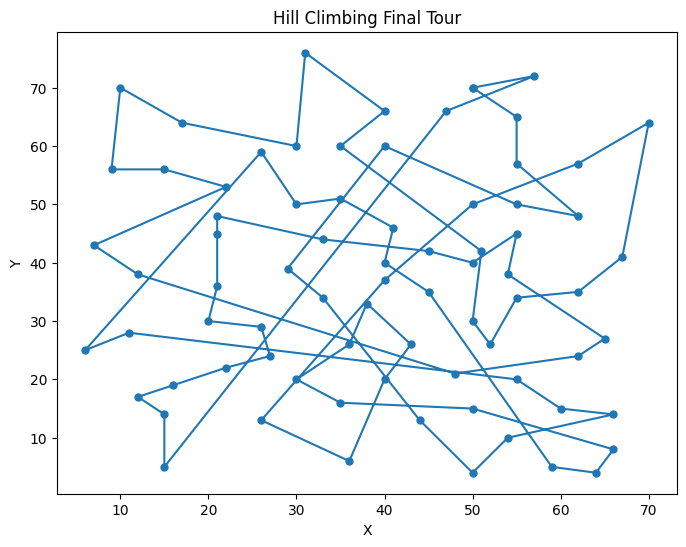

<ipython-input-208-8aea89552485>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(frame_path))


GIF saved to gifs/hill_climbing/hill_climb.gif


In [213]:
hc_tour, hc_dist, hc_reward, hc_time, hc_converge, hc_hist = hill_climb(coords)
print(f"Hill Climbing\nDistance: {hc_dist:.2f}, Reward: {hc_reward:.2f}, Time: {hc_time:.2f}s, Converged at Iteration: {hc_converge}")
plot_tour(coords, hc_tour, title="Hill Climbing Final Tour")

create_gif(coords, hc_hist, output_folder="gifs/hill_climbing", gif_name="hill_climb.gif")



Simulated Annealing
Distance: 2273.16, Reward: -2273.16, Time: 0.32s, Converged at Iteration: 223


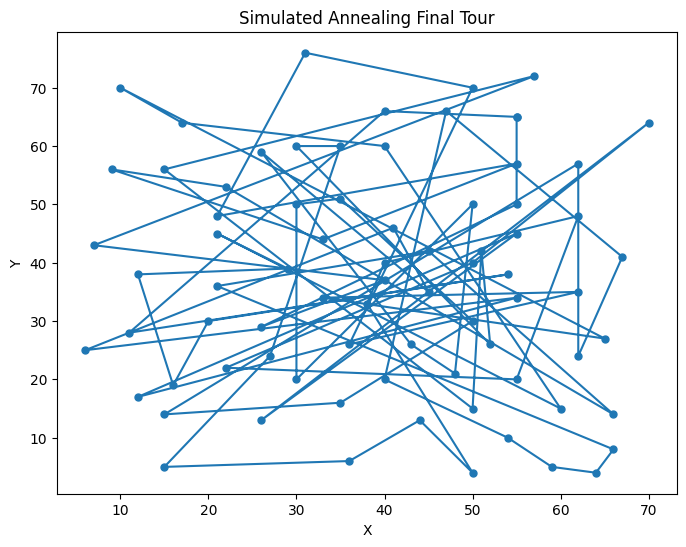

<ipython-input-208-8aea89552485>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(frame_path))


GIF saved to gifs/simulated_annealing/simulated_annealing.gif


In [216]:
sa_tour, sa_dist, sa_reward, sa_time, sa_converge, sa_hist = simulated_annealing(coords)
print(f"\nSimulated Annealing\nDistance: {sa_dist:.2f}, Reward: {sa_reward:.2f}, Time: {sa_time:.2f}s, Converged at Iteration: {sa_converge}")
plot_tour(coords, sa_tour, title="Simulated Annealing Final Tour")

create_gif(coords, sa_hist, output_folder="gifs/simulated_annealing", gif_name="simulated_annealing.gif")


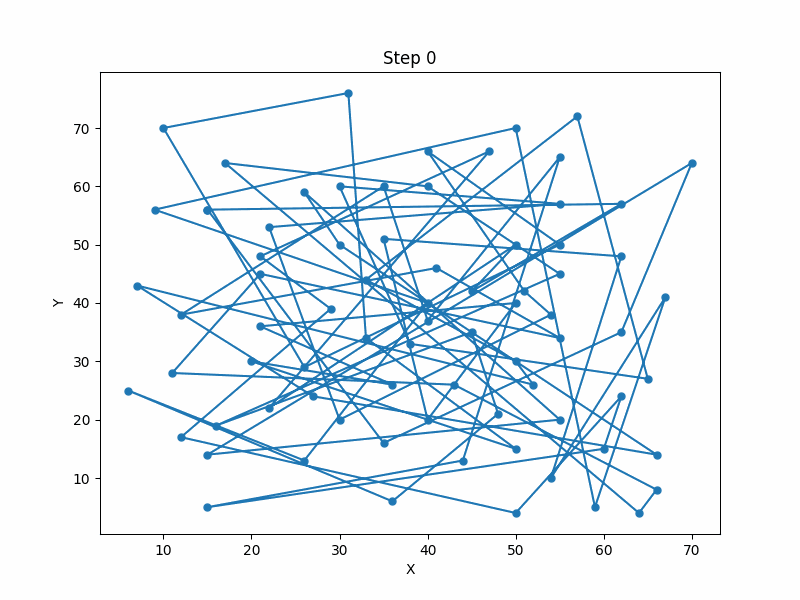

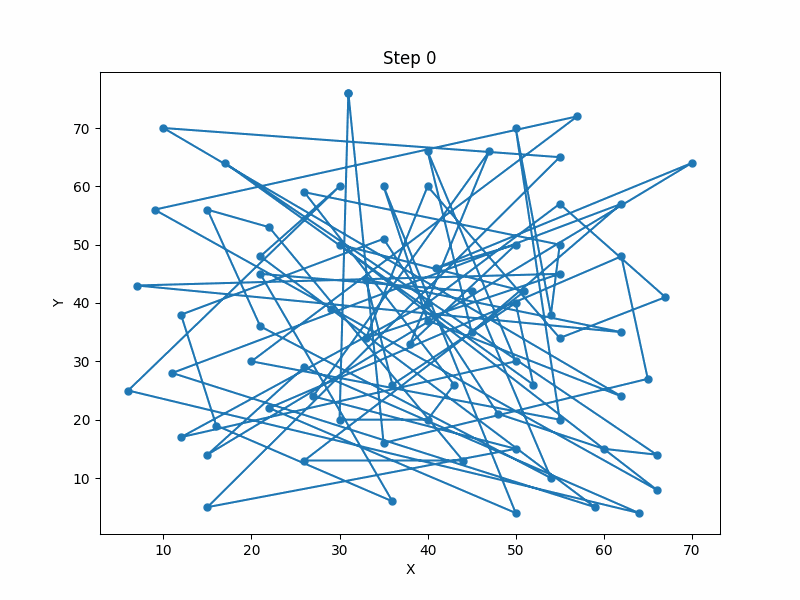

In [217]:
from IPython.display import Image, display

display(Image(filename="gifs/hill_climbing/hill_climb.gif"))

display(Image(filename="gifs/simulated_annealing/simulated_annealing.gif"))

